Neuromorphic engineering I

## Lab 6: Integrator Circuits

Group number:

Team member 1:

Team member 2:

TLJH username:

Date:

-------------------------------------------------------------------------------------------------------------------

**Objectives of this lab:** 
In this lab we will begin to explore the time domain using the follower-integrator and the follower-differentiator circuit.

Both circuits simply contain a transconductance amplifier and a capacitor to implement a low-pass or high-pass filter.

We will use the follower-integrator (FOI) and follower-differentiator circuit on the CoACH chip. The capacitance for both capacitors is $1pF$.

The objectives of the lab are:
1. Understand the behavior of the first-order low-pass follower-integrator and high-pass follower-differentiator circuit in the time and frequency domain in small signal operation.

_First-order_ means that the transfer function amplitude decreases as 1/frequency.

_Low-pass_ ( _High-pass_ ) means that the circuit passes low (high) frequencies and blocks high (low) frequencies.

_Follower-integrator_ ( _Follower-differentiator_ ) means that the output follows the input at low (high) frequencies, and integrates (differentiates) at higher (lower) frequencies.

2. Understand the large signal behavior and other limitations of using a transconductance amplifier to model a linear resistor.

# 1 Reading

See Chapters 8 and 9 of the Carver Mead book ("Analog VLSI and Neural
Systems"), paying particular attention to the time and frequency domain
treatments of the RC circuit, pages 129-130 and 137-140 in Chapter 8,
and the follower-integrator circuit, pages 147-149 and 158-162 in
Chapter 9. Slides are also available introducing linear systems analysis.


# 2 Prelab

1. How are capacitors constructed in CMOS chip technology?  There are  several different possible implementations.  How are they   constructed in neurons? What is the capacitance per square micron of a SiO$_2$ capacitor with 
	oxide thickness of 10nm?  What is the capacitance per square micron area of a lipid-bilayer 
	capacitance with thickness of 5nm? (You will need to look up the dielectric constants for 
	SiO$_2$ and lipid bilayers; remember to provide your sources in your writeup. One standard source for lipid bilayers is Ohki, Shinpei. "Dielectric constant and refractive index of lipid bilayers." Journal of Theoretical Biology 19.1 (1968): 97-115\footnote{\url{https://www.sciencedirect.com/science/article/pii/0022519368900088}}.)

Write your answer here...

2. Derive the transfer function $H(s)=\frac{V_{out}}{V_{in}}$ for the follower-integrator, using the _s_-plane notation, expressed in terms of complex frequency $s$ and the time constant $\tau$.


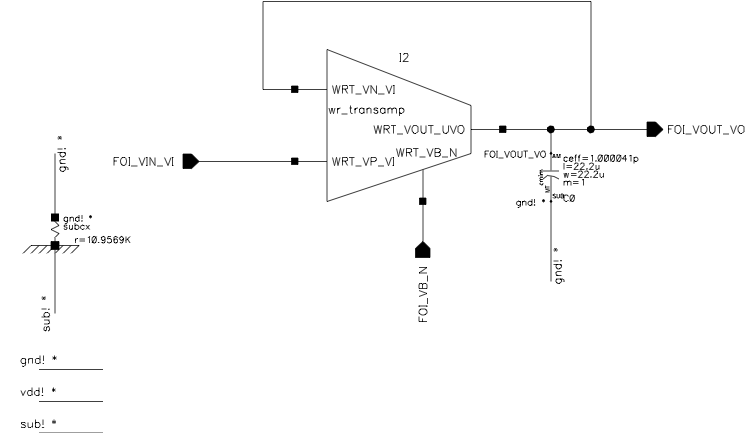

Write your answer here...

3. Compute the transfer function $H(s)=\frac{V_{out}}{V_{in}}$ for the follower-differentiator, using the _s_-plane notation, expressed in terms of complex frequency $s$ and the time constant $\tau$.

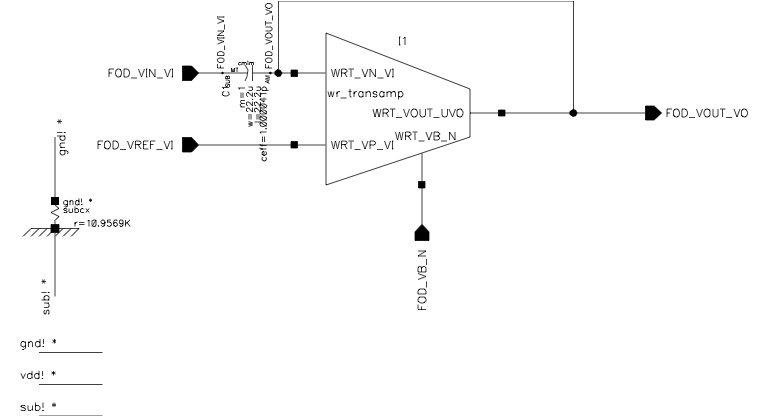

Write your answer here...

4. Compute the magnitude $|H(s)|$ for the follower integrator for input angular frequency $\omega$. At what frequency $f$ in Hz does the power drop to half its low frequency value (amplitude drops to $1/\sqrt{2}$)? 

Write your answer here...

5. Compare the simple _RC_ integrator, constructed from a resistor and a capacitor, and the follower-integrator to show how the transfer function falls short in describing the follower integrator. In particular, how does the follower integrator respond to large signal inputs? This question is related to the next one, which is

Write your answer here...

6. What does ''small-signal'' mean?  In other words, what voltage range will this regime correspond to?  For the follower-integrator circuit is it the _amplitude_ of the input or the output or the _difference_ between the two that matters? Why?


Write your answer here...

# 3 Setup

## 3.1 Connect the device

In [ ]:
# import the necessary libraries
import pyplane
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [ ]:
# create a Plane object and open the communication
if 'p' not in locals():
    p = pyplane.Plane()
    try:
        p.open('/dev/ttyACMx')
    except RuntimeError as e:
        del p
        print(e)

In [ ]:
# Send a reset signal to the board, check if the LED blinks
p.reset()

In [ ]:
# Try to read something, make sure the chip responses
p.read_current(pyplane.ReadCurrentChannel.GO0)

In [ ]:
# If any of the above steps fail, delete the object, close and halt, stop the server and ask the TA to restart
# please also say your board number: ttyACMx

# del p

## 3.1 Chip configuration

Both circuits we use today uses the same configuration, so we just need to do it once at the beginning.

In [ ]:
p.send_coach_event(pyplane.Coach.generate_aerc_event(
    pyplane.pyplane.Coach.CurrentOutputSelect.SelectLine0,
    pyplane.Coach.VoltageOutputSelect.SelectLine1,
    pyplane.Coach.VoltageInputSelect.SelectLine2,
    pyplane.Coach.SynapseSelect.NoneSelected,0))

## 3.2 Bias Generator (BiasGen or BG)

In a simplified form, the output of a branch of the BiasGen will be the gate voltage $V_b$ for the bias current $I_b$, and if the current mirror has a ratio of $w$ and the bias transistor operates in subthreshold-saturation:
\begin{equation}
I_b = w\frac{BG_{fine}}{256}I_{BG_{master}}
\end{equation}
Where $I_{BG_{master}}$ is the `BiasGenMasterCurrent` $\in \left\{ 60~\rm{pA}, 460~\rm{pA}, 3.8~\rm{nA}, 30~\rm{nA}, 240~\rm{nA} \right\}$, $BG_{fine}$ is the integer fine value $\in [0, 256)$

To set a bias, use the function similar to the following:

```
p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.BIAS_NAME_STARTS_WITH_THREE_LETTER_CIRCUIT_NAME, \
    pyplane.Coach.BiasType.MATCH_LAST_CHAR_OF_BIAS_NAME, \
    pyplane.Coach.BiasGenMasterCurrent.MASTER_CURRENT, FINE_VALUE))
```

## 3.3 Fast sampling mode

In previous labs, we have only used static circuits. In order to observe the response in microsecond-scale, we need to change the sampling mode of the microcontroller

* To set the sampling mode to `Fast`, run the following code:

In [ ]:
p.set_sampling_mode(pyplane.SamplingMode.Fast)

* If you forget which sampling mode the microcontroller is in, you can check it by running

In [ ]:
p.get_sampling_mode()

* In fast sampling mode, only up to four ADC channels can be selected to sample from (instead of all 16 as in `Slow` mode). 

We will only need two channels (ADC[9] and ADC[10]) for this lab, so you just need to run the following code once:

In [ ]:
p.set_fast_sampling_adcs([9, 10])

* If you forget which adc channels are selected, you can check it by running

In [ ]:
p.get_fast_sampling_adcs()

* The fast sampling mode is only triggered with an input. Currently only a single step response is implemented.

To acquire such a response, do something like:

```
p.acquire_transient_response(pyplane.VoltageChannel.AINX, voltage_magnitude, N_samples, delta_T)
```

where `pyplane.VoltageChannel.AINX` is the pin where you want to apply input, `voltage_magnitude` is the magnitude of the step in Volts, `N_samples` is the number of ADC samples starting from the time when the step is applied, and `delta_T` is the interval between the ADC samples.

* After this function is called, the microcontroller will return an `N_ADC_channels`-by-`N_samples` array with the samples for all channels you specified with `p.set_fast_sampling_adcs`. To read the samples of a specific channel, use 

```
p.read_adc_samples(channel_id)
```

You will be given more detailed examples later.

# 4 Follower-integrator (FOI)

## 4.1 Schematic and pin map

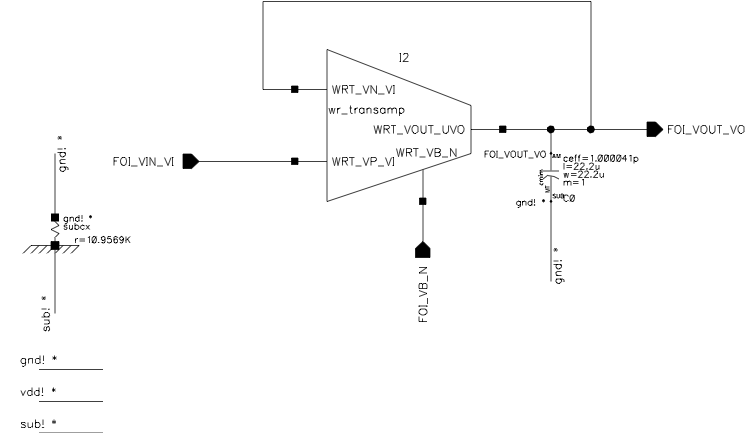

**$V_{in}$ = FOI_VIN_VI = AIN9**

**$V_{out}$ = FOI_VOUT_VO = ADC[10]**

**$C$ = ceff = 1 pF**

* The W/L of the output transistor of the BiasGen is 4u/12u, and the bias transistor $M_b$ of wide-range-transamp is 1u/1u, which give a ratio of **$w$ = 3**. This means if you set the bias current to (3.8 nA, 225), you will get $I_b = 3.8\times\frac{67}{256}\times3 = 3$ nA instead of 1 nA.

## 4.2 Time-domain response of small signal

### 4.2.1 Set parameters

* The maximum sampling frequency of the ADC is 100 kHz (10 $\mu$s), and the maximum number of samples is 250. Let's say if we want to cover the time period of $10\tau$ with these 250 samples, what should the value of $\tau$ be (assume $\kappa=1$)?

* To get this $\tau$, what is the value of $I_b$?

* What `MasterCurrent` and `fine` value should we use for $I_b$? Please set below.

In [ ]:
p.send_coach_event(pyplane.Coach.generate_biasgen_event(
    pyplane.Coach.BiasAddress.FOI_VB_N,
    pyplane.Coach.BiasType.N,
    ..., ...))

* What should the input before the step $\left(V_{in}(t < 0)\right)$ be (Hint: common-mode voltage of the (wide-range) transamp)? What is the corresponding $V_{out}$ in steady state $\left(V_{out}(t=0^-)\right)$? 

In [ ]:
Vi_pre = ...

* What does "small signal" mean? What should the magnitude of the step input ($\Delta V_{in}$) be so that it can be treated as "small"?

In [ ]:
dVi = ...

### 4.2.2 Data aquisition

* Verify the stead state

In [ ]:
p.set_voltage(pyplane.VoltageChannel.AIN9, Vi_pre)
time.sleep(0.5) # wait for the circuit to reach steady state
Vo_pre = p.read_adc_instantaneous(10)

* There is a small offset of the DAC of around -10 mV, but the ADC is correct, so we want to correct `Vi_pre` accordingly.

In [ ]:
Vi_off = ... - Vi_pre
Vi_pre_corr = Vi_pre - Vi_off

* Complete the following code to acquire the step response and average over 10 trials.

In [ ]:
N_trials = 10 # average over 10 trials to reduce error
N_samples = 250 # maximum number of samples = 250
dT = 10 # time interval between samples, in microseconds
t = np.arange(0, N_samples) * dT * 1e-6
vo = np.zeros(N_samples) # output voltage
for i in range(N_trials):
    p.set_voltage(pyplane.VoltageChannel.AIN9, Vi_pre_corr)
    time.sleep(0.5) # wait for the circuit to reach steady state
    p.acquire_transient_response(pyplane.VoltageChannel.AIN9, Vi_pre_corr + dVi, N_samples, dT)
    time.sleep(0.5) # wait to receive the measured data from the microcontroller
    vo = vo + p.read_adc_samples(10)
vo = vo/N_trials

* plot $V_{out}$

* save data

### 4.2.3 Compute the time constant $\tau$ by reading from the decay in the curve

* Assume the input step happens at exactly $t=0$, what is the expression of $V_{out}$ at $t = \tau$?

$V_{out}(t=\tau) =$

* Compute $\tau$ by "reading" this point from the curve:

In [ ]:
f = interpolate.interp1d(..., ...)
v_1tau = ...
tau1 = ...

* Compute the actual $\kappa$ by comparing the measured $\tau$ and the estimated value in 4.2.1 with $\kappa=1$.

### 4.2.4 Compute the time constant $\tau$ by fitting the curve in semilogy plot

* Which variable (Hint: an expression containing $V_{out}(t)$ and $V_{out}(t=+\infty)$) has an exponential dependency on $t$?

* Verify you hypothesis by showing in a semilogy plot.

* Compute $\tau$ by fitting the linear range in the curve

* Compute the actual $\kappa$ by comparing the measured $\tau$ and the expected value in 4.2.1 with $\kappa=1$.

### 4.2.5 Analysis

* Is the "small signal" assumption validated by the measurement? Why or why not?

* Is the assumption "input step happens at exactly $t=0$" validated by the measurement? How can you get the actual time it takes place?

* Is there any difference between the $\tau$ values computed using the two methods? Which one is more accurate? Why? What can be the causes for the errors?

### 4.2.6 (Optional) Rise and fall times

* Repeat the steps with a negative $\Delta V_{in}$. Compare the time constant $\tau$ (choose one methond you prefer to compute $\tau$).

* Looking at the circuit, what could cause this mismatch of rise and fall behavior?

### 4.2.7 (Optional) Different bias currents

* Repeat the steps with a different $I_b$. Compare the time constant $\tau$ (no need to compute, just show the two curves in the same plot).

* Does the valid range of "small signal" change?

### 4.2.8 (Optional) Different DC levels

* Try to decrease the DC level of the input $\left(V_{in}(t < 0)\right)$. Capture strange behavior you observe and explain it. (Hint: Consider the operating range of the transconductance amplifier.)

## 4.3 Time-domain response of large signal

### 4.3.1 Set parameters

* What does "large signal" mean? What should the magnitude of the step input ($\Delta V_{in}$) be so that it can be treated as "large"?

In [ ]:
dVi = ...

* What should the input before the step $\left(V_{in}(t < 0)\right)$ be (Hint: common-mode voltage of the (wide-range) transamp)? What is the corresponding $V_{out}$ in steady state $\left(V_{out}(t=0^-)\right)$? 

In [ ]:
Vi_pre = ...

* Let's still set ADC sampling rate as 100 kHz (10 $\mu$s), and the maximum number of samples as 250. If we want the linear part to be about 40% of the whole sampled period, what should the slew rate be (Hint: in [V/s])?

* To get this slew rate, what is the value of $I_b$ (Hint: $C$ = 1 pF)?

* What `MasterCurrent` and `fine` value should we use for $I_b$? Please set below.

In [ ]:
p.send_coach_event(pyplane.Coach.generate_biasgen_event(
    pyplane.Coach.BiasAddress.FOI_VB_N,
    pyplane.Coach.BiasType.N,
    ..., ...))

### 4.3.2 Data aquisition

* Verify the stead state

* There is a small offset of the DAC of around -10 mV, but the ADC is correct, so we want to correct the DAC accordingly.

* Acquire the step response and average over 10 trials.

* plot $V_{out}$

* save data

### 4.3.3 Data processing

* Compute the slew rate by fitting the linear part of the curve

* Calculate the bias current $I_b$ from the slew rate and compare it with the set value. Comment on possible reason of any discrepancy.

* Compute the time constant $\tau$ and the $\kappa$ by fitting the exponential part of the curve. Do they make sense?

### 4.3.4 Analysis

* Is the assumption "input step happens at exactly $t=0$" validated by the measurement? How can you get the actual time it takes place?

* Could you give a marginal value of $\Delta V_{in}$ between "small" and large signal"? (Hint: assume for the transamp, $I_{out} \propto (V_1-V_2)$ iff $g_m|V_1-V_2| < I_b$)

### 4.3.5 (Optional) Rise and fall times

* Repeat the steps with a negative $\Delta V_{in}$. Compare time constant $\tau$ (choose one methond you prefer to compute $\tau$).

* Looking at the circuit, what could cause this mismatch of rise and fall behavior? Compared to small signal response, is the mismatch bigger or smaller? Why?

### 4.3.6 (Optional) Different bias currents

* Repeat the steps with a different $I_b$. Compare the slew rate.

## 4.4 Frequency-domain response

### 4.4.1 Methodology

In the prelab we have computed the magnitude of the transfer function $H(s)$. In this exercise we are going to measure this curve and read the cutoff frequency ($\omega = 2 \pi f$ such that $H(s = j \omega)=\frac{1}{\sqrt{2}}\angle-45^\circ$).

* What will the output signal $V_{out}$ look like if the input $V_{in}$ is a sine wave in steady state (after several cycles)?

* In order to apply a sine wave, we have to set the DAC to many (>= 20) different values within one cycle. You could play with following code to see how good the approximation is:

In [ ]:
N_samples = 20 # 20 points per period of the sine
settle_time = 0.1 # assume it takes 0.1 times the interval for the DAC to settle
x = np.repeat(np.arange(0,1,1/N_samples)*2*np.pi,1/settle_time)
y = np.sin(x)
plt.plot(np.arange(N_samples/settle_time)*settle_time,y)

* In order to make the measurement more accurate, we set $I_b$ to minimum (about 0.7 pA):

In [ ]:
p.send_coach_event(pyplane.Coach.generate_biasgen_event(
    pyplane.Coach.BiasAddress.FOI_VB_N,
    pyplane.Coach.BiasType.N,
    pyplane.Coach.BiasGenMasterCurrent.I60pA,1))

* With this $I_b$, what is the cutoff frequency approximately?

### 4.4.2 Observe the input and output waveforms

* First try to complete with the following code to observe 

In [ ]:
vi_offset = 0.9 # offset of the input sine wave
vi_amplitude = 0.1 # amplitude of the input sine wave
N_repeats = 10 # how many times we repeat the input
adc_sample_rate = 500 # ADC sample rate [Hz], <= 500 Hz, DO NOT CHANGE
dT = 1/adc_sample_rate # delta t between ADC(DAC) samples
dac_samples_per_period = 40 # 40 DAC samples per input period
freq = adc_sample_rate/dac_samples_per_period # input frequency
N_samples = dac_samples_per_period*N_repeats # total number of samples
t = np.arange(0, N_samples)*dT
vi_set = vi_offset + vi_amplitude*np.sin(np.linspace(0, 2*np.pi, dac_samples_per_period))
vi = np.zeros(N_samples)
vo = np.zeros(N_samples)
for j in range(N_repeats):
    for i in range(dac_samples_per_period):
        n = i + j*dac_samples_per_period
        p.set_voltage(pyplane.VoltageChannel.AIN9, vi_set[i])
        vi[n] = p.get_set_voltage(pyplane.VoltageChannel.AIN9)
        time.sleep(dT)
        vo[n] = p.read_adc_instantaneous(10)

* Plot $V_{in}$ and $V_{out}$ in the same figure

* Save data

* Is the circuit "following" or "integrating"?

* Can you change the frequency to make it operate in the other regime?

* Plot $V_{in}$ and $V_{out}$ in the same figure

* Save data

### 4.4.3 Compute the transfer function at one frequency

* Because of the offset error of $V_{in}$, run the following code to subtract the DC component

In [ ]:
vi_ac = vi-np.mean(vi)
vo_ac = vo-np.mean(vo)

* We can use the Fourier transform to get the gain and the phase shift of the transfer function at the input frequency (no need to know the detail)

In [ ]:
fi = np.fft.fft(vi_ac)
fo = np.fft.fft(vo_ac)
gain = np.abs(fo[N_repeats])/np.abs(fi[N_repeats])
phase = np.rad2deg(np.angle(fo[N_repeats]) - np.angle(fi[N_repeats]))

### 4.4.4 Measure the frequency response

* Repeat the steps in 4.4.2 and 4.4.3 to measure at least 7 points covering 2 decades around the cutoff frequency estimated in 4.4.1.

* Save data

### 4.4.5 Extract the cutoff frequency

* Plot the gain magintude vs frequency

* What is the cutoff frequency read from the magnitude plot? (Hint: Use `interpolate.interp1d` to get the exact value)

* Plot the phase shift vs frequency

* What is the cutoff frequency read from the phase plot? (Hint: Use `interpolate.interp1d` to get the exact value)

* Are the cutoff frequency values got in these two figures identical? What could be a reason if not?

# 5 Follower-differentiator (FOD)

## 5.1 Schematic and pin map

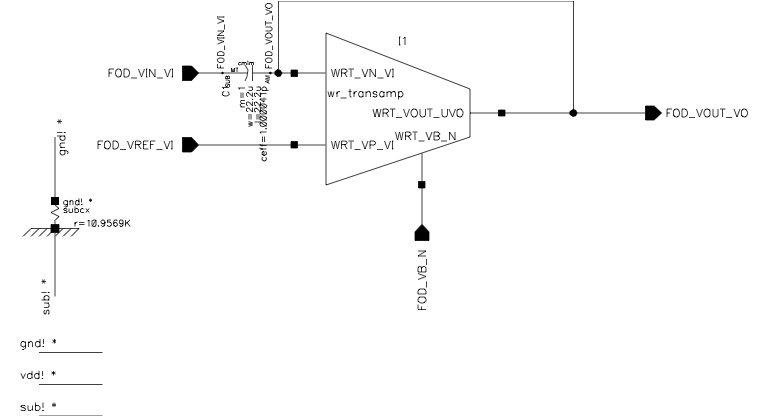

**FOD_VIN_VI = AIN10**

**FOD_VREF_VI = AIN11**

**FOD_VOUT_VO = ADC[9]**

**$C$ = ceff = 1 pF**

## 5.2 Time-domain response of small signal

### 5.2.1 Set parameters

* Set the same $I_b$, $V_{in}(t < 0) = V_{ref}$ and $\Delta V_{in}$ as 4.2.1.

In [ ]:
p.send_coach_event(pyplane.Coach.generate_biasgen_event(
    pyplane.Coach.BiasAddress.FOD_VB_N,
    pyplane.Coach.BiasType.N,
    ..., ...))

In [ ]:
Vi_pre = ...

In [ ]:
# set V_ref

In [ ]:
dVi = ...

### 5.2.2 Data aquisition

* Verify the stead state

* There is a small offset of the DAC of around -10 mV, but the ADC is correct, so we want to correct the DAC accordingly.

* Aquire the step response and average over 10 trials.

* plot $V_{out}$

* save data

### 5.2.3 Comparison of FOI and FOD

* Plot the output of the two circuits in the same figure. Do you think they are doing good integration/differentiation?

### 5.2.4 (Optional) Rise and fall times

* Repeat the steps using the same parameters as 4.2.6 (FOI).

* Compare with the result in 5.2.2 by plotting them in the same figure (rise time vs fall time).

* Compare with the result in 4.2.6 by plotting them in the same figure (FOI vs FOD).

### 5.2.5 (Optional) Different bias currents

* Repeat the steps using the same parameters as 4.2.7.

* Compare with the result in 5.2.2 by plotting them in the same figure (different bias currents).

* Compare with the result in 4.2.7 by plotting them in the same figure (FOI vs FOD).

## 5.3 Time-domain response of large signal

### 5.3.1 Set parameters

* Set the same $\Delta V_{in}$, $V_{in}(t < 0) = V_{ref}$, $I_b$ as 4.3.1.

In [ ]:
dVi = ...

In [ ]:
Vi_pre = ...

In [ ]:
p.send_coach_event(pyplane.Coach.generate_biasgen_event(
    pyplane.Coach.BiasAddress.FOD_VB_N,
    pyplane.Coach.BiasType.N,
    ..., ...))

### 5.3.2 Data aquisition

* Verify the stead state

* There is a small offset of the DAC of around -10 mV, but the ADC is correct, so we want to correct the DAC accordingly.

In [ ]:
# set V_ref

* Complete the following code to acquire the average step response over 10 trials.

* plot $V_{out}$

* save data

* what is the maximum value $V_{out}$ reaches? Is it the same as $V_{in}(t>0)$? What could be a reason if not?

### 5.3.3 Comparison of FOI and FOD

* Plot the output of the two circuits in the same figure.

### 5.3.4 (Optional) Rise and fall times

* Repeat the steps using the same parameters as 4.3.5 (FOI).

* Compare with the result in 5.3.2 by plotting them in the same figure (rise time vs fall time).

* Compare with the result in 4.3.5 by plotting them in the same figure (FOI vs FOD).

### 5.3.5 (Optional) Different bias currents

* Repeat the steps using the same parameters as 4.3.6.

* Compare with the result in 5.3.2 by plotting them in the same figure (different bias currents).

* Compare with the result in 4.3.6 by plotting them in the same figure (FOI vs FOD).

## 5.4 Frequency-domain response

### 5.4.1 Methodology

The cutoff frequency for the FOD circuit as a high-pass filter is slightly different from low-pass filter is the  frequency $\omega_c=2 \pi f_c$ s.t. $H(s=j\omega_c)=\frac{1}{\sqrt{2}}\angle45^\circ$.

* In order to make the measurement more accurate, we still set $I_b$ to minimum (about 0.7 pA):

In [ ]:
p.send_coach_event(pyplane.Coach.generate_biasgen_event(
    pyplane.Coach.BiasAddress.FOD_VB_N,
    pyplane.Coach.BiasType.N,
    pyplane.Coach.BiasGenMasterCurrent.I60pA,1))

* With this $I_b$, what is the cutoff frequency approximately?

### 5.4.2 Observe the input and output waveforms

* Set the input frequency as 4.4.2 and acquire the output waveform

* Plot $V_{in}$ and $V_{out}$ in the same figure

* Save data

* Is the circuit "following" or "integrating"?

* Can you change the frequency to make it operate in the other regime?

* Plot $V_{in}$ and $V_{out}$ in the same figure

* Save data

* What is the maximum gain (Hint: when the phase shift between $V_{in}$ and $V_{out}$ is close to 0, i.e. at high frequency)? What could be a reason if it is not 1?

### 5.4.3 Compute the transfer function at one frequency

* Because of the offset error of $V_{in}$, run the following code to subtract the DC component

In [ ]:
vi_ac = vi-np.mean(vi)
vo_ac = vo-np.mean(vo)

* We can use the Fourier transform to get the gain and the phase shift of the transfer function at the input frequency (no need to know the detail)

In [ ]:
fi = np.fft.fft(vi_ac)
fo = np.fft.fft(vo_ac)
gain = np.abs(fo[N_repeats])/np.abs(fi[N_repeats])
phase = np.rad2deg(np.angle(fo[N_repeats]) - np.angle(fi[N_repeats]))

### 5.4.4 Measure the frequency response

* Repeat the steps in 5.4.2 and 5.4.3 to measure at least 7 points covering 2 decades around the cutoff frequency estimated in 5.4.1.

* Save data

### 5.4.5 Data analysis

* Plot the gain magintude vs frequency

* Plot the phase shift vs frequency

* Give a rough estimation of the cutoff frequency by just looking at the curves, without calculation. (Hint: A more precise definition is $\omega_c=2 \pi f_c$ s.t. $H(s=j\omega_c)=\frac{H_{\max}}{\sqrt{2}}\angle45^\circ$.)

* Compare the results with 4.4.5 (FOI vs FOD), comment on anything interesting you observe.

# 6 Postlab

1. The continuous-time RC or follower integrator acts as an _integrator_ over only a certain frequency range. What is this frequency range and what happens for frequencies outside this range?

Write here your answer

2. You may have noticed a difference in the up and down-going slew rates in the follower integrator. Do you expect this difference to show up in the rise and fall time constants for linear operation of the circuit?

Write here your answer

3. The asymmetry in the slew rate means that for large signals, the average voltage of the follower-integrator output (it's DC value) will not be equal to the average level of the input voltage. Explain why.

Write here your answer

4. How would running the follower-integrator above threshold change   the small and large signal operation of the circuit?

Write here your answer

5. As you computed in the pre-lab for the follower-differentiator, if you turn the RC integrator around, the RC integrator can be used as a CR differentiator. Diagram how and compute the frequency range over which the CR differentiator actually differentiates. Also diagram the equivalent follower-differentiator. What happens outside this range of frequencies?

Write here your answer